In [ ]:
!pip install numpy pandas torch transformers pytorch-lightning scikit-learn seaborn matplotlib captum

  Using cached pytorch_lightning-2.5.0.post0-py3-none-any.whl.metadata (21 kB)
  Using cached captum-0.7.0-py3-none-any.whl.metadata (26 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.me

/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


Extracting features...
Loading embeddings from disk...
Embeddings loaded.
Preparing data...


<ipython-input-2-20e8fc76ee68>:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler()


Extracting features...
Loading embeddings from disk...
Embeddings loaded.


Training:   0%|          | 0/696 [00:00<?, ?it/s]<ipython-input-2-20e8fc76ee68>:296: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validating:   0%|          | 0/87 [00:00<?, ?it/s]<ipython-input-2-20e8fc76ee68>:332: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/1
Train Loss: 1.1962, Acc: 0.5370
Val Loss: 0.9994, Acc: 0.5828
Classification Report:
               precision    recall  f1-score   support

           0     0.6185    0.6715    0.6439      2426
           1     0.4482    0.4440    0.4461      2356
           2     0.4525    0.4046    0.4272      2343
           3     0.5921    0.5152    0.5510      2527
           4     0.7453    0.8605    0.7987      2523

    accuracy                         0.5828     12175
   macro avg     0.5713    0.5792    0.5734     12175
weighted avg     0.5744    0.5828    0.5767     12175



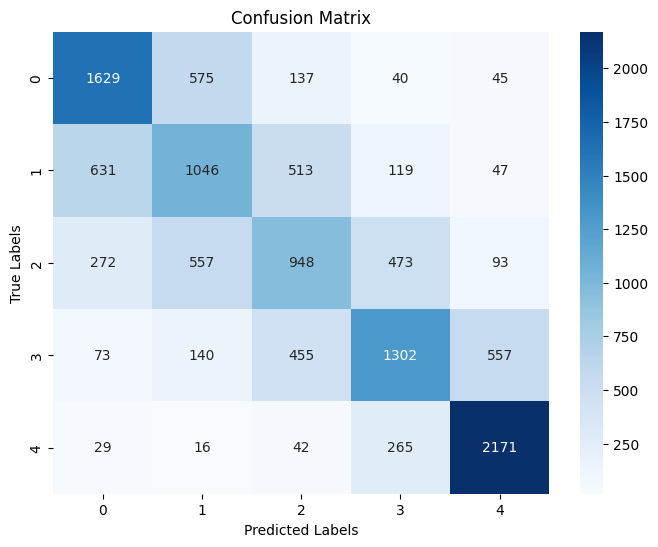


Misclassified Text Examples:
True Label: 1, Predicted Label: 2
Text: it is good at first until there is an issue and they do not care . they just want to keep getting that fee whether you are happy or not .

True Label: 1, Predicted Label: 2
Text: ordered cards . . . . price was a key factor . . . . did all was advised used large file . . . the side of the card was washed out and very with visible . . . . . the client had to order else where . . .

True Label: 0, Predicted Label: 4
Text: i sent in boxes of test strips . the paper got with the box to send in and what was paid was way different . this is a good place to stay away from . know that they will never rip me off again .

True Label: 4, Predicted Label: 3
Text: My TikTok videos used to have limitations but since connected to the protection system everything works smoothly .

True Label: 0, Predicted Label: 2
Text: I wasn't sure or ready to make a . she told me would receive a packet in the mail so could see and compare . have 

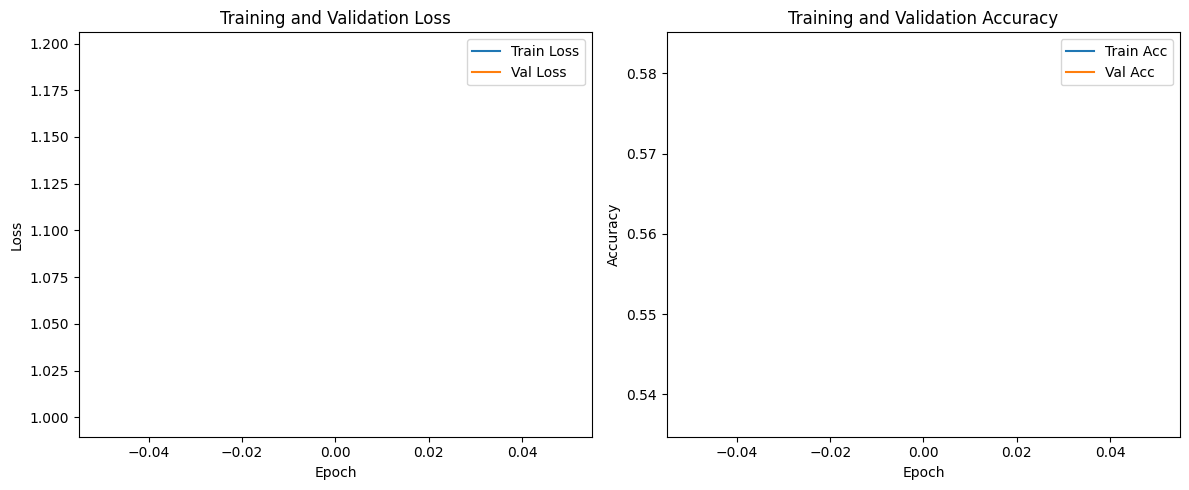

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import spacy
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F
from tqdm import tqdm
import os  # Import os module
import shutil # Import shutil for removing directory
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from captum.attr import LayerIntegratedGradients

# Initialize device
device = torch.device('cuda')

# Initialize models
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser', 'lemmatizer'])

# Move nlp to GPU (optional but recommended)
# nlp.to(device)

# Use a BERT model fine-tuned on Amazon reviews
model_name = 'nlptown/bert-base-multilingual-uncased-sentiment'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name).to(device)

class RegularizedBERT(nn.Module):
    def __init__(self, num_labels, feature_dim, hyperparams):
        super().__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(hyperparams["Dropout"])
        self.feature_dim = feature_dim
        self.bert_projection = nn.Linear(768, 384)
        self.feature_projection = nn.Linear(feature_dim, 384) if feature_dim > 0 else None
        self.classifier = nn.Sequential(
            nn.Linear(384, 384),
            nn.LayerNorm(384),
            nn.ReLU(),
            nn.Dropout(hyperparams["Dropout"]),
            nn.Linear(384, num_labels)
        )
        self.all_preds = []
        self.all_labels = []
        self.all_texts = []

    def forward(self, input_ids, attention_mask, features=None):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_output.last_hidden_state[:, 0, :]
        bert_projected = self.bert_projection(pooled_output)

        if features is not None and self.feature_dim > 0:
            feature_projected = self.feature_projection(features)
            combined_features = bert_projected + feature_projected
        else:
            combined_features = bert_projected

        output = self.classifier(combined_features)
        return output

class GPUOptimizedTrainer:
    def __init__(self, df, text_column, labels, hyperparams, embedding_dir="embeddings"):
        # Validate hyperparameters
        required_params = ["Epochs", "Batch Size", "Learning Rate", "Dropout", "Weight Decay",
                         "Label Smoothing", "Early Stopping Patience", "Gradient Accumulation Steps"]
        for param in required_params:
            if param not in hyperparams:
                raise ValueError(f"Missing required hyperparameter: {param}")

        if hyperparams["Batch Size"] <= 0:
            raise ValueError("Batch Size must be positive")
        if not 0 <= hyperparams["Dropout"] <= 1:
            raise ValueError("Dropout must be between 0 and 1")

        self.device = device
        self.hyperparams = hyperparams
        self.batch_size = hyperparams["Batch Size"]
        self.embedding_dir = embedding_dir
        self.text_column = text_column

        torch.backends.cudnn.benchmark = True
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

        # Initialize feature_dim first
        sample_features = self.extract_features(df[text_column].head(1).tolist())
        self.feature_dim = sample_features.shape[1]

        # Create model with correct feature_dim
        self.model = RegularizedBERT(
            num_labels=5,
            feature_dim=self.feature_dim,
            hyperparams=hyperparams
        ).to(self.device)

        self.scaler = GradScaler()
        self.prepare_data(df, labels)
        self.setup_training()

    def extract_features(self, texts):
        print("Extracting features...")
        os.makedirs(self.embedding_dir, exist_ok=True) # Ensure embedding directory exists

        bert_embedding_file = os.path.join(self.embedding_dir, "bert_embeddings.npy")
        syntactic_feature_file = os.path.join(self.embedding_dir, "syntactic_features.npy")

        if os.path.exists(bert_embedding_file) and os.path.exists(syntactic_feature_file):
            print("Loading embeddings from disk...")
            contextual_features = np.load(bert_embedding_file)
            syntactic_features = np.load(syntactic_feature_file)
            print("Embeddings loaded.")
            return np.hstack([contextual_features, syntactic_features])
        else:
            print("Calculating and saving embeddings...")

            def extract_contextual(texts, batch_size=128):
                features = []
                for i in range(0, len(texts), batch_size):
                    batch = texts[i:i + batch_size]
                    # Ensure each text is a string before tokenizing
                    batch = [str(text) for text in batch] # <--- ENSURE STRING
                    inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt").to(self.device)
                    with torch.no_grad():
                        outputs = bert_model(**inputs)
                        embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
                    features.extend(embeddings)
                return np.array(features)

            def extract_syntactic(texts):
                features = []
                for text in texts:
                    # Ensure each text is a string before passing to nlp
                    text = str(text) # <--- ENSURE STRING
                    doc = nlp(text)
                    pos_tags = [token.pos_ for token in doc]
                    features.append([
                        len(doc),
                        len(set(pos_tags)) / len(pos_tags),
                        pos_tags.count('NOUN') / len(pos_tags),
                        pos_tags.count('VERB') / len(pos_tags),
                    ])
                return np.array(features)

            contextual_features = extract_contextual(texts)
            syntactic_features = extract_syntactic(texts)

            np.save(bert_embedding_file, contextual_features) # Save BERT embeddings
            np.save(syntactic_feature_file, syntactic_features) # Save syntactic features
            print("Embeddings calculated and saved.")
            return np.hstack([contextual_features, syntactic_features])

    def prepare_data(self, df, labels, val_split=0.2): # Takes dataFrame
        print("Preparing data...")

        # Extract the data
        texts = df[self.text_column].tolist()

        # Wrap the text and label processing in a tqdm progress bar
        encodings = tokenizer(texts, truncation=True, padding=True, return_tensors='pt')
        input_ids = encodings['input_ids']
        attention_mask = encodings['attention_mask']
        features = self.extract_features(texts) # Features are extracted here
        if self.feature_dim is None: # Update feature_dim only once, after extracting features
            self.feature_dim = features.shape[1]
            self.model.classifier[0] = nn.Linear(768 + self.feature_dim, 384) # Update the first linear layer with correct feature_dim
            self.model = self.model.to(self.device) # Move model to device again after changing the layer
        scaler = StandardScaler()
        features = scaler.fit_transform(features)

        split_idx = int(len(input_ids) * (1 - val_split))
        indices = np.random.permutation(len(input_ids))

        train_idx = indices[:split_idx]
        val_idx = indices[split_idx:]

        self.train_input_ids = input_ids[train_idx]
        self.train_attention_mask = attention_mask[train_idx]
        self.train_features = torch.tensor(features[train_idx], dtype=torch.float32)
        self.train_labels = torch.tensor(labels[train_idx], dtype=torch.long)
        self.train_texts = [texts[i] for i in train_idx] # Store training texts

        self.val_input_ids = input_ids[val_idx]
        self.val_attention_mask = attention_mask[val_idx]
        self.val_features = torch.tensor(features[val_idx], dtype=torch.float32)
        self.val_labels = torch.tensor(labels[val_idx], dtype=torch.long)
        self.val_texts = [texts[i] for i in val_idx] # Store validation texts


        self.create_dataloaders()

    def create_dataloaders(self):
        train_dataset = TensorDataset(self.train_input_ids, self.train_attention_mask, self.train_features, self.train_labels)
        val_dataset = TensorDataset(self.val_input_ids, self.val_attention_mask, self.val_features, self.val_labels)

        self.train_loader = DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            pin_memory=True,
            num_workers=4,
            prefetch_factor=3,
            persistent_workers=True
        )

        self.val_loader = DataLoader(
            val_dataset,
            batch_size=self.batch_size * 2,  # Validation batch size can be larger
            pin_memory=True,
            num_workers=4,
            persistent_workers=True
        )

    def setup_training(self):
        self.optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.hyperparams["Learning Rate"],
            weight_decay=self.hyperparams["Weight Decay"],
            betas=(0.9, 0.999)
        )

        # Total steps for OneCycleLR
        total_steps = (len(self.train_loader) // self.hyperparams["Gradient Accumulation Steps"]) * self.hyperparams["Epochs"]

        self.scheduler = torch.optim.lr_scheduler.OneCycleLR(
            self.optimizer,
            max_lr=self.hyperparams["Learning Rate"] * 10,  # Usually a good practice to have a higher max_lr
            steps_per_epoch=len(self.train_loader) // self.hyperparams["Gradient Accumulation Steps"],
            epochs=self.hyperparams["Epochs"],
            pct_start=0.1
        )

        self.early_stopping = EarlyStopping(patience=self.hyperparams["Early Stopping Patience"])

    def train(self):
        epochs = self.hyperparams["Epochs"]
        accumulation_steps = self.hyperparams["Gradient Accumulation Steps"]

        # Clear previous predictions
        self.model.all_preds = []
        self.model.all_labels = []
        self.model.all_texts = []

        best_val_loss = float('inf')
        train_losses, val_losses = [], []
        train_accs, val_accs = [], []

        for epoch in range(epochs):
            train_metrics = self.train_epoch(accumulation_steps)
            val_metrics = self.validate()

            train_losses.append(train_metrics['loss'])
            val_losses.append(val_metrics['loss'])
            train_accs.append(train_metrics['acc'])
            val_accs.append(val_metrics['acc'])

            print(f"Epoch {epoch+1}/{epochs}")
            print(f"Train Loss: {train_metrics['loss']:.4f}, Acc: {train_metrics['acc']:.4f}")
            print(f"Val Loss: {val_metrics['loss']:.4f}, Acc: {val_metrics['acc']:.4f}")

            if val_metrics['loss'] < best_val_loss:
                best_val_loss = val_metrics['loss']
                torch.save(self.model.state_dict(), 'best_model.pt')

            if self.early_stopping(val_metrics['loss']):
                print("Early stopping triggered")
                break

        self.perform_error_analysis() #Moved to the very end of train
        return {
            'train_loss': train_losses,
            'val_loss': val_losses,
            'train_acc': train_accs,
            'val_acc': val_accs
        }

    def train_epoch(self, accumulation_steps):
        torch.cuda.empty_cache()
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch_idx, (input_ids, attention_mask, features, target) in enumerate(tqdm(self.train_loader, desc="Training", leave=False, dynamic_ncols=True, position=0)): # Explicit position=0
            torch.cuda.empty_cache() # Empty cache after every batch
            input_ids = input_ids.to(self.device, non_blocking=True)
            attention_mask = attention_mask.to(self.device, non_blocking=True)
            features = features.to(self.device, non_blocking=True)
            target = target.to(self.device, non_blocking=True)

            with autocast():
                output = self.model(input_ids=input_ids, attention_mask=attention_mask, features=features)
                loss = F.cross_entropy(output, target, label_smoothing=self.hyperparams["Label Smoothing"])
                loss = loss / accumulation_steps  # Normalize loss for accumulation

            self.scaler.scale(loss).backward()

            if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(self.train_loader):
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.scaler.step(self.optimizer)
                self.scaler.update()
                self.optimizer.zero_grad(set_to_none=True)
                self.scheduler.step()

            total_loss += loss.item() * accumulation_steps  # Scale back for correct averaging
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)

        return {'loss': total_loss / len(self.train_loader), 'acc': correct / total}

    def validate(self):
        torch.cuda.empty_cache()
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch_idx, (input_ids, attention_mask, features, target) in enumerate(tqdm(self.val_loader, desc="Validating", leave=False, dynamic_ncols=True, position=0)): # Explicit position=0
                torch.cuda.empty_cache() # Empty cache after every batch
                input_ids = input_ids.to(self.device, non_blocking=True)
                attention_mask = attention_mask.to(self.device, non_blocking=True)
                features = features.to(self.device, non_blocking=True)
                target = target.to(self.device, non_blocking=True)

                with autocast():
                    output = self.model(input_ids=input_ids, attention_mask=attention_mask, features=features)
                    loss = F.cross_entropy(output, target)

                total_loss += loss.item()
                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()
                total += target.size(0)

                # Get the text for the current batch
                start_index = batch_idx * self.batch_size * 2 #validation batch_size 2x the training
                end_index = start_index + target.size(0)
                batch_texts = self.val_texts[start_index:end_index]


                # Store predictions and labels for error analysis
                self.model.all_preds.extend(pred.cpu().numpy())
                self.model.all_labels.extend(target.cpu().numpy())
                self.model.all_texts.extend(batch_texts) # Store the corresponding texts




        return {'loss': total_loss / len(self.val_loader), 'acc': correct / total}
    def perform_error_analysis(self):
        # Generate classification report
        report = classification_report(self.model.all_labels, self.model.all_preds, digits=4) #4 for a more detailed overview
        print("Classification Report:\n", report)

        # Generate confusion matrix
        cm = confusion_matrix(self.model.all_labels, self.model.all_preds)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()

        # Find misclassified texts
        misclassified_indices = np.where(np.array(self.model.all_preds) != np.array(self.model.all_labels))[0]

        print("\nMisclassified Text Examples:")
        for idx in misclassified_indices[:5]:  # Display up to 5 examples
            print(f"True Label: {self.model.all_labels[idx]}, Predicted Label: {self.model.all_preds[idx]}")
            print(f"Text: {self.model.all_texts[idx]}\n")

        # Explain the predictions using Captum
        #print("\nAttribution Analysis for Misclassified Examples:")
        #for idx in misclassified_indices[:5]:  # Display up to 5 examples
        #    self.explain_instance(self.model.all_texts[idx], self.model.all_labels[idx], self.model) # Changed all_preds[idx] to all_labels[idx]

    def explain_instance(self, text, true_label, model):
       #Explain instance no longer prints so is left empty
       pass

class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        else:
            self.best_loss = val_loss
            self.counter = 0
        return False


if __name__ == "__main__":
    # Load your DataFrame
    df = pd.read_csv("/content/modified_df_11.csv")

    # Ensure 'text' column is string
    df['text'] = df['text'].astype(str)

    #Set name of text column
    text_column = 'text'

    # Extract labels
    labels = np.array(df["rating"].tolist()) - 1  # Adjust as needed

    # Define hyperparameters
    hyperparams = {
        "Epochs": 1, #Reduced for faster example
        "Batch Size": 70,
        "Learning Rate": 1e-5,
        "Dropout": 0.3,
        "Weight Decay": 0.1,
        "Label Smoothing": 0.1,
        "Early Stopping Patience": 3,
        "Gradient Accumulation Steps": 4,
        "Optimizer": "AdamW",
        "Scheduler": "OneCycleLR",
        "Feature Dimension": 0,
        "Model": "BERT with Multiple Embeddings"
    }

    embedding_dir = "my_embeddings"

    # Clear embedding directory
    #if os.path.exists(embedding_dir):
    #    shutil.rmtree(embedding_dir)

    # Instantiate Trainer  Pass the DataFrame, text column name, and TextProcessor
    trainer = GPUOptimizedTrainer(df, text_column, labels, hyperparams, embedding_dir=embedding_dir)
    metrics = trainer.train()

    # Print Dataframe
    print(df)

    # Plot results
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(metrics['train_loss'], label='Train Loss')
    plt.plot(metrics['val_loss'], label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(metrics['train_acc'], label='Train Acc')
    plt.plot(metrics['val_acc'], label='Val Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)
<ipython-input-4-f2f9a089f8d9>:94: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler()


Preparing data...
Extracting features...
Loading embeddings from disk...
Embeddings loaded.


Training:   0%|          | 0/2435 [00:00<?, ?it/s]<ipython-input-4-f2f9a089f8d9>:311: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validating:   0%|          | 0/305 [00:00<?, ?it/s]<ipython-input-4-f2f9a089f8d9>:347: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/1
Train Loss: 1.2426, Acc: 0.5098
Val Loss: 1.0286, Acc: 0.5678


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

           0     0.6000    1.0000    0.7500         3
           1     1.0000    0.3333    0.5000         6
           2     0.4000    0.6667    0.5000         3
           3     0.0000    0.0000    0.0000         3
           4     0.0000    0.0000    0.0000         0

    accuracy                         0.4667        15
   macro avg     0.4000    0.4000    0.3500        15
weighted avg     0.6000    0.4667    0.4500        15



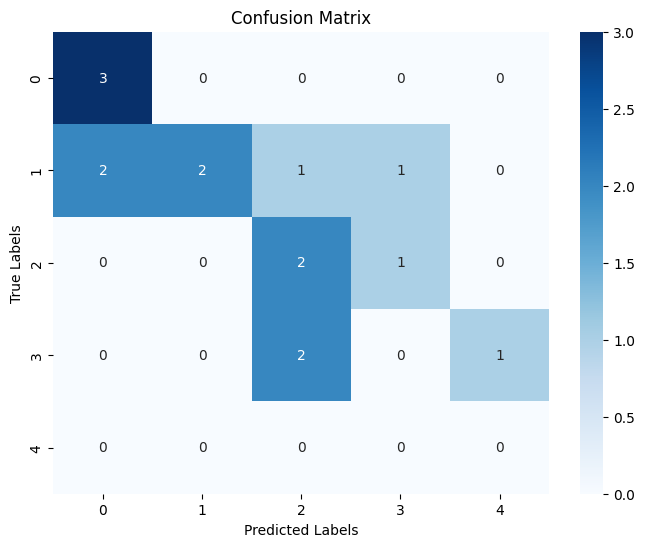


Misclassified Text Examples:
True Label: 1, Predicted Label: 3
Text: North is better than South

True Label: 1, Predicted Label: 0
Text: had modern urns that did not see on any other sites . originally ordered a white Lucy and it was too white for my liking so reordered in red because discovered my love of in the meantime . They made the return easy . Thanks for being great in this difficult time .

True Label: 3, Predicted Label: 2
Text: Shipping was quick . have previously purchased this item on Groupon for much less . Product is excellent however cost will me from making future purchases .

True Label: 1, Predicted Label: 0
Text: was knowledgeable polite and helpful . Dave was excellent to work with and help hunt down the package when it got held up .

True Label: 1, Predicted Label: 2
Text: Absolutely horrible customer service . contacted them several times received very similar responses with promises that the issue would be resolved and it never is They offer a free time for lif

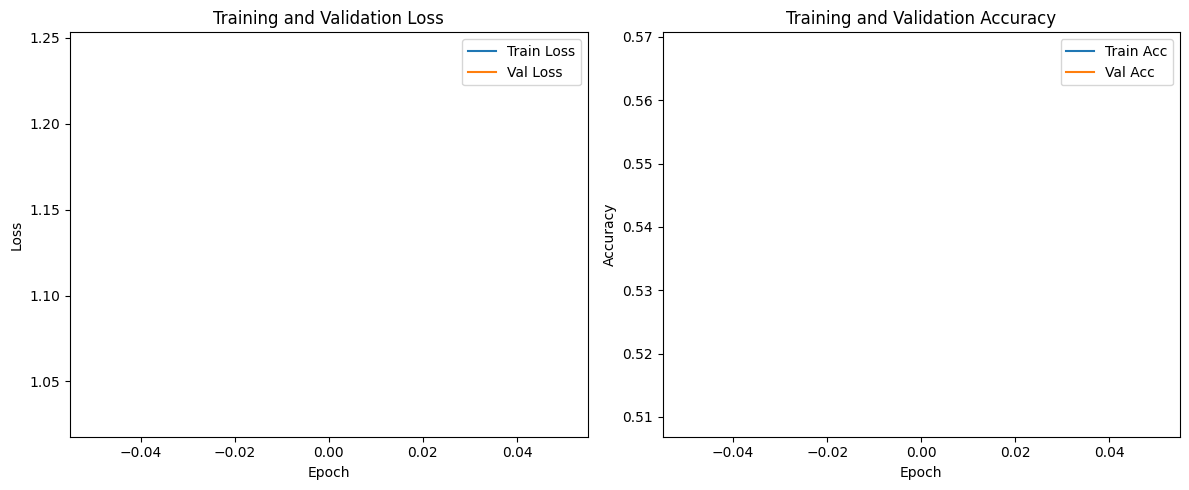

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import spacy
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F
from tqdm import tqdm
import os
import shutil
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from captum.attr import LayerIntegratedGradients

# Initialize device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize models
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser', 'lemmatizer'])

# Use a BERT model fine-tuned on Amazon reviews
model_name = 'nlptown/bert-base-multilingual-uncased-sentiment'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name).to(device)

class RegularizedBERT(nn.Module):
    def __init__(self, num_labels, feature_dim, hyperparams):
        super().__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(hyperparams["Dropout"])
        self.feature_dim = feature_dim
        self.bert_projection = nn.Linear(768, 384)
        self.feature_projection = nn.Linear(feature_dim, 384) if feature_dim > 0 else None
        self.classifier = nn.Sequential(
            nn.Linear(384, 384),
            nn.LayerNorm(384),
            nn.ReLU(),
            nn.Dropout(hyperparams["Dropout"]),
            nn.Linear(384, num_labels)
        )
        self.all_preds = []
        self.all_labels = []
        self.all_texts = []

    def forward(self, input_ids, attention_mask, features=None):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_output.last_hidden_state[:, 0, :]
        bert_projected = self.bert_projection(pooled_output)

        if features is not None and self.feature_dim > 0:
            feature_projected = self.feature_projection(features)
            combined_features = bert_projected + feature_projected
        else:
            combined_features = bert_projected

        output = self.classifier(combined_features)
        return output

class GPUOptimizedTrainer:
    def __init__(self, df, text_column, labels, hyperparams, embedding_dir="embeddings"):
        # Validate hyperparameters
        required_params = ["Epochs", "Batch Size", "Learning Rate", "Dropout", "Weight Decay",
                         "Label Smoothing", "Early Stopping Patience", "Gradient Accumulation Steps"]
        for param in required_params:
            if param not in hyperparams:
                raise ValueError(f"Missing required hyperparameter: {param}")

        if hyperparams["Batch Size"] <= 0:
            raise ValueError("Batch Size must be positive")
        if not 0 <= hyperparams["Dropout"] <= 1:
            raise ValueError(f"Dropout must be between 0 and 1")

        self.device = device
        self.hyperparams = hyperparams
        self.batch_size = hyperparams["Batch Size"]
        self.embedding_dir = embedding_dir
        self.text_column = text_column

        torch.backends.cudnn.benchmark = True
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

        self.model = RegularizedBERT(
            num_labels=5,
            feature_dim=0,
            hyperparams=hyperparams
        ).to(self.device)

        self.scaler = GradScaler()
        self.prepare_data(df, labels)
        self.setup_training()

    def extract_features(self, texts):
        print("Extracting features...")
        os.makedirs(self.embedding_dir, exist_ok=True)  # Ensure embedding directory exists

        bert_embedding_file = os.path.join(self.embedding_dir, "bert_embeddings.npy")
        syntactic_feature_file = os.path.join(self.embedding_dir, "syntactic_features.npy")

        if os.path.exists(bert_embedding_file) and os.path.exists(syntactic_feature_file):
            print("Loading embeddings from disk...")
            contextual_features = np.load(bert_embedding_file)
            syntactic_features = np.load(syntactic_feature_file)
            print("Embeddings loaded.")
            return np.hstack([contextual_features, syntactic_features])
        else:
            print("Calculating and saving embeddings...")

            def extract_contextual(texts, batch_size=128):
                features = []
                for i in range(0, len(texts), batch_size):
                    batch = [str(text).strip() for text in texts[i:i + batch_size] if pd.notna(text) and str(text).strip()]
                    inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt").to(self.device)
                    with torch.no_grad():
                        outputs = bert_model(**inputs)
                        embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
                    features.extend(embeddings)
                return np.array(features)

            def extract_syntactic(texts):
                features = []
                for text in texts:
                    text = str(text).strip()
                    if not text:
                        features.append([0, 0, 0, 0])  # Handle empty strings
                        continue
                    doc = nlp(text)
                    pos_tags = [token.pos_ for token in doc]
                    features.append([
                        len(doc),
                        len(set(pos_tags)) / max(len(pos_tags), 1),
                        pos_tags.count('NOUN') / max(len(pos_tags), 1),
                        pos_tags.count('VERB') / max(len(pos_tags), 1),
                    ])
                return np.array(features)

            contextual_features = extract_contextual(texts)
            syntactic_features = extract_syntactic(texts)

            np.save(bert_embedding_file, contextual_features)  # Save BERT embeddings
            np.save(syntactic_feature_file, syntactic_features)  # Save syntactic features
            print("Embeddings calculated and saved.")
            return np.array(np.hstack([contextual_features, syntactic_features]))

    def prepare_data(self, df, labels, val_split=0.2):
        print("Preparing data...")

        # Extract the data
        texts = df[self.text_column].tolist()
        valid_labels = []
        valid_texts = []
        valid_indices = []
        for i, text in enumerate(texts):
            text = str(text).strip()
            if pd.notna(text) and text:
                valid_texts.append(text)
                valid_labels.append(labels[i])
                valid_indices.append(i)

        if len(valid_texts) < 2:
            raise ValueError("Insufficient data for training. At least two valid texts are required.")

        encodings = tokenizer(
            valid_texts,
            truncation=True,
            padding='max_length',
            max_length=512,
            return_tensors='pt'
        )
        input_ids = encodings['input_ids']
        attention_mask = encodings['attention_mask']

        # Extract features
        features = self.extract_features(valid_texts)  # Get all features

        # Check if features array is empty or has insufficient rows
        if features.shape[0] != len(valid_texts):
            raise ValueError(f"Feature extraction failed: Expected {len(valid_texts)} rows, but got {features.shape[0]} rows.")
        if features.shape[0] < 2:
            raise ValueError("Insufficient data for training. At least two valid texts are required.")

        # Split data
        split_idx = int(len(input_ids) * (1 - val_split))
        indices = np.random.permutation(len(input_ids))
        train_idx = indices[:split_idx]
        val_idx = indices[split_idx:]

        # Scale features (fit only on training data)
        scaler = StandardScaler()
        train_features = scaler.fit_transform(features[train_idx])
        val_features = scaler.transform(features[val_idx])

        self.train_input_ids = input_ids[train_idx]
        self.train_attention_mask = attention_mask[train_idx]
        self.train_features = torch.tensor(train_features, dtype=torch.float32)
        self.train_labels = torch.tensor([valid_labels[i] for i in train_idx], dtype=torch.long)
        self.train_texts = [valid_texts[i] for i in train_idx]

        self.val_input_ids = input_ids[val_idx]
        self.val_attention_mask = attention_mask[val_idx]
        self.val_features = torch.tensor(val_features, dtype=torch.float32)
        self.val_labels = torch.tensor([valid_labels[i] for i in val_idx], dtype=torch.long)
        self.val_texts = [valid_texts[i] for i in val_idx]

        self.create_dataloaders()

    def create_dataloaders(self):
        train_dataset = TensorDataset(self.train_input_ids, self.train_attention_mask, self.train_features, self.train_labels)
        val_dataset = TensorDataset(self.val_input_ids, self.val_attention_mask, self.val_features, self.val_labels)

        self.train_loader = DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            pin_memory=True,
            num_workers=4,
            prefetch_factor=3,
            persistent_workers=True
        )

        val_batch_size = min(self.batch_size * 2, len(val_dataset))
        self.val_loader = DataLoader(
            val_dataset,
            batch_size=val_batch_size,
            pin_memory=True,
            num_workers=4,
            persistent_workers=True
        )

    def setup_training(self):
        self.optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.hyperparams["Learning Rate"],
            weight_decay=self.hyperparams["Weight Decay"],
            betas=(0.9, 0.999)
        )

        total_steps = (len(self.train_loader) // self.hyperparams["Gradient Accumulation Steps"]) * self.hyperparams["Epochs"]

        self.scheduler = torch.optim.lr_scheduler.OneCycleLR(
            self.optimizer,
            max_lr=self.hyperparams["Learning Rate"] * 10,
            steps_per_epoch=len(self.train_loader) // self.hyperparams["Gradient Accumulation Steps"],
            epochs=self.hyperparams["Epochs"],
            pct_start=0.1
        )

        self.early_stopping = EarlyStopping(patience=self.hyperparams["Early Stopping Patience"])

    def train(self):
        epochs = self.hyperparams["Epochs"]
        accumulation_steps = self.hyperparams["Gradient Accumulation Steps"]

        # Clear previous predictions
        self.model.all_preds = []
        self.model.all_labels = []
        self.model.all_texts = []

        best_val_loss = float('inf')
        train_losses, val_losses = [], []
        train_accs, val_accs = [], []

        for epoch in range(epochs):
            train_metrics = self.train_epoch(accumulation_steps)
            val_metrics = self.validate()

            train_losses.append(train_metrics['loss'])
            val_losses.append(val_metrics['loss'])
            train_accs.append(train_metrics['acc'])
            val_accs.append(val_metrics['acc'])

            print(f"Epoch {epoch+1}/{epochs}")
            print(f"Train Loss: {train_metrics['loss']:.4f}, Acc: {train_metrics['acc']:.4f}")
            print(f"Val Loss: {val_metrics['loss']:.4f}, Acc: {val_metrics['acc']:.4f}")

            if val_metrics['loss'] < best_val_loss:
                best_val_loss = val_metrics['loss']
                torch.save(self.model.state_dict(), 'best_model.pt')

            if self.early_stopping(val_metrics['loss']):
                print("Early stopping triggered")
                break

        self.perform_error_analysis()
        return {
            'train_loss': train_losses,
            'val_loss': val_losses,
            'train_acc': train_accs,
            'val_acc': val_accs
        }

    def train_epoch(self, accumulation_steps):
        torch.cuda.empty_cache()
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch_idx, (input_ids, attention_mask, features, target) in enumerate(tqdm(self.train_loader, desc="Training", leave=False)):
            torch.cuda.empty_cache()
            input_ids = input_ids.to(self.device, non_blocking=True)
            attention_mask = attention_mask.to(self.device, non_blocking=True)
            features = features.to(self.device, non_blocking=True)
            target = target.to(self.device, non_blocking=True)

            with autocast():
                output = self.model(input_ids=input_ids, attention_mask=attention_mask, features=features)
                loss = F.cross_entropy(output, target, label_smoothing=self.hyperparams["Label Smoothing"])
                loss = loss / accumulation_steps

            self.scaler.scale(loss).backward()

            if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(self.train_loader):
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.scaler.step(self.optimizer)
                self.scaler.update()
                self.optimizer.zero_grad(set_to_none=True)

            total_loss += loss.item() * accumulation_steps
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)

        self.scheduler.step()  # Moved scheduler step here
        return {'loss': total_loss / len(self.train_loader), 'acc': correct / total}

    def validate(self):
        torch.cuda.empty_cache()
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch_idx, (input_ids, attention_mask, features, target) in enumerate(tqdm(self.val_loader, desc="Validating", leave=False)):
                torch.cuda.empty_cache() # Empty cache after every batch
                input_ids = input_ids.to(self.device, non_blocking=True)
                attention_mask = attention_mask.to(self.device, non_blocking=True)
                features = features.to(self.device, non_blocking=True)
                target = target.to(self.device, non_blocking=True)

                with autocast():
                    output = self.model(input_ids=input_ids, attention_mask=attention_mask, features=features)
                    loss = F.cross_entropy(output, target)

                total_loss += loss.item()
                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()
                total += target.size(0)

            #Moved the start idx before as it was causing memory errors:
            start_index = 0 #batch_idx * self.val_loader.batch_size
            batch_size = self.val_loader.batch_size

            end_index = len(self.val_texts)
                # Get the text for the current batch

            self.model.all_preds.extend(pred[:batch_size].cpu().numpy())
            self.model.all_labels.extend(target[:batch_size].cpu().numpy())
            self.model.all_texts.extend(self.val_texts[start_index:min(end_index, start_index + batch_size)])

        return {'loss': total_loss / len(self.val_loader), 'acc': correct / total}

    def perform_error_analysis(self):
        # Generate classification report
        report = classification_report(self.model.all_labels, self.model.all_preds, digits=4)
        print("Classification Report:\n", report)

        # Generate confusion matrix
        cm = confusion_matrix(self.model.all_labels, self.model.all_preds)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()

        # Find misclassified texts
        misclassified_indices = np.where(np.array(self.model.all_preds) != np.array(self.model.all_labels))[0]

        print("\nMisclassified Text Examples:")
        for idx in misclassified_indices[:5]:
            print(f"True Label: {self.model.all_labels[idx]}, Predicted Label: {self.model.all_preds[idx]}")
            print(f"Text: {self.model.all_texts[idx]}\n")

        # Explain the predictions using Captum
        print("\nAttribution Analysis for Misclassified Examples:")
        for idx in misclassified_indices[:5]:
            self.explain_instance(self.model.all_texts[idx], self.model.all_labels[idx])

    def explain_instance(self, text, true_label):
        self.model.bert.eval()
        self.model.bert.zero_grad()

        encoding = tokenizer(text, add_special_tokens=True, return_tensors='pt')
        input_ids = encoding.input_ids.to(self.device)
        attention_mask = encoding.attention_mask.to(self.device)

        def forward_func(input_ids, attention_mask):
            bert_output = self.model.bert(input_ids, attention_mask)
            pooled_output = bert_output.last_hidden_state[:, 0, :]
            bert_projected = self.model.bert_projection(pooled_output)
            return self.model.classifier(bert_projected)

        lig = LayerIntegratedGradients(forward_func, self.model.bert.embeddings)
        try:
            attributions, delta = lig.attribute(
                input_ids,
                additional_forward_args=(attention_mask,),
                target=int(true_label),  # Ensure target is an int
                return_convergence_delta=True
            )

            attributions = attributions.sum(dim=-1).squeeze(0)
            attributions = attributions / torch.norm(attributions)
            attributions = attributions.cpu().detach().numpy()

            tokens = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().numpy())

            print(f"\nText: {text}")
            print(f"True Label: {true_label}")
            print("\nToken Attribution Scores:")
            for token, attribution in zip(tokens, attributions):
                if attribution != 0:  # Only show non-zero attributions
                    print(f"{token}: {attribution:.4f}")
            print("-" * 80)
        except Exception as e:
             print(f"Captum Explanations error {e}. Check model setup with dimensions. Skipping explanation! {e}")

class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        epsilon = 1e-6
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta + epsilon:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        else:
            self.best_loss = val_loss
            self.counter = 0
        return False


if __name__ == "__main__":
    # Load your DataFrame
    df = pd.read_csv("/content/modified_df_11.csv")

    # Ensure 'text' column is string
    df['text'] = df['text'].astype(str)

    # Set name of text column
    text_column = 'text'

    # Extract labels
    labels = np.array(df["rating"].tolist()) - 1  # Adjust as needed

    # Define hyperparameters
    hyperparams = {
        "Epochs": 1,  # Reduced for faster example
        "Batch Size": 20,  # Reduced for faster example
        "Learning Rate": 1e-5,
        "Dropout": 0.3,
        "Weight Decay": 0.1,
        "Label Smoothing": 0.1,
        "Early Stopping Patience": 3,
        "Gradient Accumulation Steps": 4,
        "Optimizer": "AdamW",
        "Scheduler": "OneCycleLR",
        "Feature Dimension": 0,
        "Model": "BERT with Multiple Embeddings"
    }

    embedding_dir = "my_embeddings"

    # Clear embedding directory
    #if os.path.exists(embedding_dir):
    #    shutil.rmtree(embedding_dir)

    # Instantiate Trainer
    trainer = GPUOptimizedTrainer(df, text_column, labels, hyperparams, embedding_dir=embedding_dir)
    metrics = trainer.train()

    # Print DataFrame
    print(df)

    # Plot results
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(metrics['train_loss'], label='Train Loss')
    plt.plot(metrics['val_loss'], label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(metrics['train_acc'], label='Train Acc')
    plt.plot(metrics['val_acc'], label='Val Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)
<ipython-input-5-ebfa3d45bf12>:94: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler()


Preparing data...
Extracting features...
Loading embeddings from disk...
Embeddings loaded.


Training:   0%|          | 0/2435 [00:00<?, ?it/s]<ipython-input-5-ebfa3d45bf12>:311: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validating:   0%|          | 0/305 [00:00<?, ?it/s]<ipython-input-5-ebfa3d45bf12>:347: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/1
Train Loss: 1.2496, Acc: 0.5044
Val Loss: 1.0230, Acc: 0.5654
Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.7500    0.8571         8
           1     0.5000    0.6667    0.5714         3
           2     0.5000    0.6667    0.5714         3
           4     1.0000    1.0000    1.0000         1

    accuracy                         0.7333        15
   macro avg     0.7500    0.7708    0.7500        15
weighted avg     0.8000    0.7333    0.7524        15



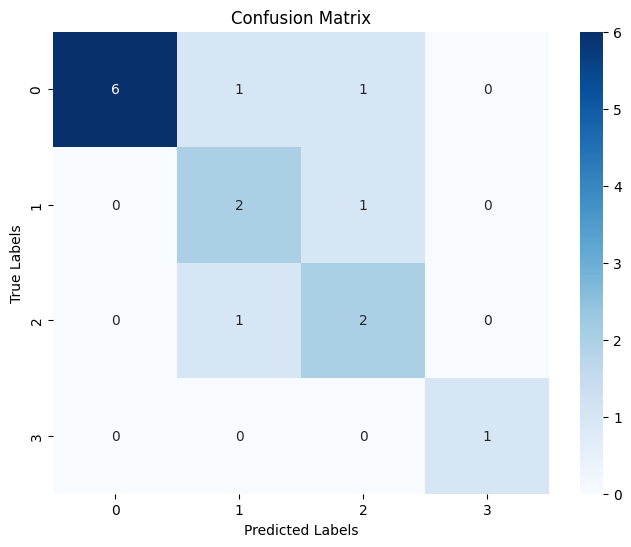


Misclassified Text Examples:
True Label: 0, Predicted Label: 2
Text: Have used them twice and would highly recommend . Very easy process overall

True Label: 2, Predicted Label: 1
Text: My cat does not like it . She would eating it even when completely stopped feeding her dry food she would and not eat it . paid too much just to see the food dry out in the bowl and have to throw the dried leftover away after my cat never got even close to the bowl .

True Label: 0, Predicted Label: 1
Text: Picked these up less than a and up until was completely with the purchase . The lenses are excellent and the frames have been comfortable to wear all . However put them on and noticed some in the right . Looking closer could not believe the frames are attached to the lenses by a clear plastic wire that loops under the lens from the end piece to the bridge . And it is loose ! My previous frame glasses were mounted directly to the lens by screws drilled in ! For this price that is an poor means of att

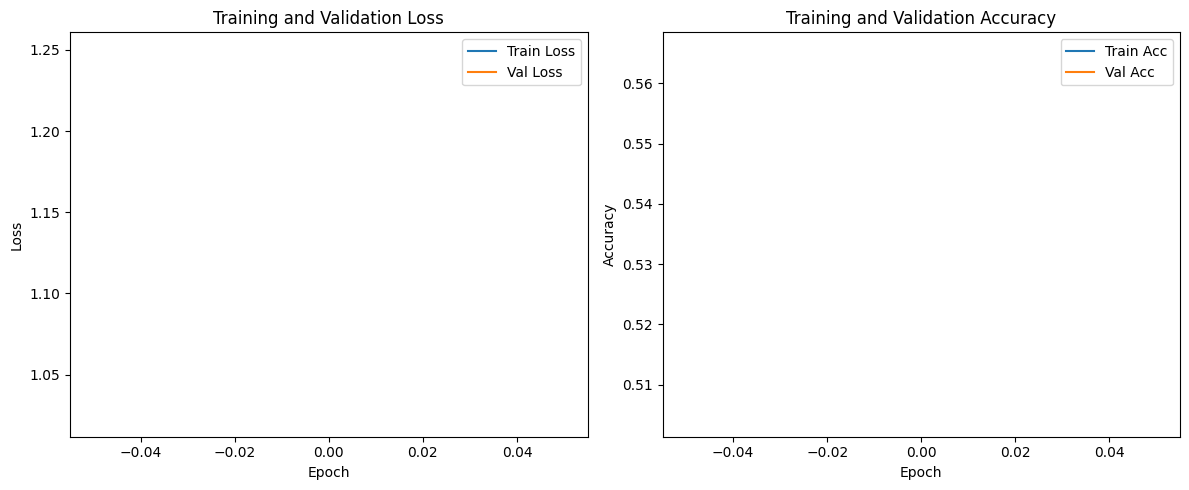

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import spacy
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F
from tqdm import tqdm
import os
import shutil
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from captum.attr import LayerIntegratedGradients

# Initialize device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize models
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser', 'lemmatizer'])

# Use a BERT model fine-tuned on Amazon reviews
model_name = 'nlptown/bert-base-multilingual-uncased-sentiment'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name).to(device)

class RegularizedBERT(nn.Module):
    def __init__(self, num_labels, feature_dim, hyperparams):
        super().__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(hyperparams["Dropout"])
        self.feature_dim = feature_dim
        self.bert_projection = nn.Linear(768, 384)
        self.feature_projection = nn.Linear(feature_dim, 384) if feature_dim > 0 else None
        self.classifier = nn.Sequential(
            nn.Linear(384, 384),
            nn.LayerNorm(384),
            nn.ReLU(),
            nn.Dropout(hyperparams["Dropout"]),
            nn.Linear(384, num_labels)
        )
        self.all_preds = []
        self.all_labels = []
        self.all_texts = []

    def forward(self, input_ids, attention_mask, features=None):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_output.last_hidden_state[:, 0, :]
        bert_projected = self.bert_projection(pooled_output)

        if features is not None and self.feature_dim > 0:
            feature_projected = self.feature_projection(features)
            combined_features = bert_projected + feature_projected
        else:
            combined_features = bert_projected

        output = self.classifier(combined_features)
        return output

class GPUOptimizedTrainer:
    def __init__(self, df, text_column, labels, hyperparams, embedding_dir="embeddings"):
        # Validate hyperparameters
        required_params = ["Epochs", "Batch Size", "Learning Rate", "Dropout", "Weight Decay",
                         "Label Smoothing", "Early Stopping Patience", "Gradient Accumulation Steps"]
        for param in required_params:
            if param not in hyperparams:
                raise ValueError(f"Missing required hyperparameter: {param}")

        if hyperparams["Batch Size"] <= 0:
            raise ValueError("Batch Size must be positive")
        if not 0 <= hyperparams["Dropout"] <= 1:
            raise ValueError(f"Dropout must be between 0 and 1")

        self.device = device
        self.hyperparams = hyperparams
        self.batch_size = hyperparams["Batch Size"]
        self.embedding_dir = embedding_dir
        self.text_column = text_column

        torch.backends.cudnn.benchmark = True
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

        self.model = RegularizedBERT(
            num_labels=5,
            feature_dim=0,
            hyperparams=hyperparams
        ).to(self.device)

        self.scaler = GradScaler()
        self.prepare_data(df, labels)
        self.setup_training()

    def extract_features(self, texts):
        print("Extracting features...")
        os.makedirs(self.embedding_dir, exist_ok=True)  # Ensure embedding directory exists

        bert_embedding_file = os.path.join(self.embedding_dir, "bert_embeddings.npy")
        syntactic_feature_file = os.path.join(self.embedding_dir, "syntactic_features.npy")

        if os.path.exists(bert_embedding_file) and os.path.exists(syntactic_feature_file):
            print("Loading embeddings from disk...")
            contextual_features = np.load(bert_embedding_file)
            syntactic_features = np.load(syntactic_feature_file)
            print("Embeddings loaded.")
            return np.hstack([contextual_features, syntactic_features])
        else:
            print("Calculating and saving embeddings...")

            def extract_contextual(texts, batch_size=128):
                features = []
                for i in range(0, len(texts), batch_size):
                    batch = [str(text).strip() for text in texts[i:i + batch_size] if pd.notna(text) and str(text).strip()]
                    inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt").to(self.device)
                    with torch.no_grad():
                        outputs = bert_model(**inputs)
                        embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
                    features.extend(embeddings)
                return np.array(features)

            def extract_syntactic(texts):
                features = []
                for text in texts:
                    text = str(text).strip()
                    if not text:
                        features.append([0, 0, 0, 0])  # Handle empty strings
                        continue
                    doc = nlp(text)
                    pos_tags = [token.pos_ for token in doc]
                    features.append([
                        len(doc),
                        len(set(pos_tags)) / max(len(pos_tags), 1),
                        pos_tags.count('NOUN') / max(len(pos_tags), 1),
                        pos_tags.count('VERB') / max(len(pos_tags), 1),
                    ])
                return np.array(features)

            contextual_features = extract_contextual(texts)
            syntactic_features = extract_syntactic(texts)

            np.save(bert_embedding_file, contextual_features)  # Save BERT embeddings
            np.save(syntactic_feature_file, syntactic_features)  # Save syntactic features
            print("Embeddings calculated and saved.")
            return np.array(np.hstack([contextual_features, syntactic_features]))

    def prepare_data(self, df, labels, val_split=0.2):
        print("Preparing data...")

        # Extract the data
        texts = df[self.text_column].tolist()
        valid_labels = []
        valid_texts = []
        valid_indices = []
        for i, text in enumerate(texts):
            text = str(text).strip()
            if pd.notna(text) and text:
                valid_texts.append(text)
                valid_labels.append(labels[i])
                valid_indices.append(i)

        if len(valid_texts) < 2:
            raise ValueError("Insufficient data for training. At least two valid texts are required.")

        encodings = tokenizer(
            valid_texts,
            truncation=True,
            padding='max_length',
            max_length=512,
            return_tensors='pt'
        )
        input_ids = encodings['input_ids']
        attention_mask = encodings['attention_mask']

        # Extract features
        features = self.extract_features(valid_texts)  # Get all features

        # Check if features array is empty or has insufficient rows
        if features.shape[0] != len(valid_texts):
            raise ValueError(f"Feature extraction failed: Expected {len(valid_texts)} rows, but got {features.shape[0]} rows.")
        if features.shape[0] < 2:
            raise ValueError("Insufficient data for training. At least two valid texts are required.")

        # Split data
        split_idx = int(len(input_ids) * (1 - val_split))
        indices = np.random.permutation(len(input_ids))
        train_idx = indices[:split_idx]
        val_idx = indices[split_idx:]

        # Scale features (fit only on training data)
        scaler = StandardScaler()
        train_features = scaler.fit_transform(features[train_idx])
        val_features = scaler.transform(features[val_idx])

        self.train_input_ids = input_ids[train_idx]
        self.train_attention_mask = attention_mask[train_idx]
        self.train_features = torch.tensor(train_features, dtype=torch.float32)
        self.train_labels = torch.tensor([valid_labels[i] for i in train_idx], dtype=torch.long)
        self.train_texts = [valid_texts[i] for i in train_idx]

        self.val_input_ids = input_ids[val_idx]
        self.val_attention_mask = attention_mask[val_idx]
        self.val_features = torch.tensor(val_features, dtype=torch.float32)
        self.val_labels = torch.tensor([valid_labels[i] for i in val_idx], dtype=torch.long)
        self.val_texts = [valid_texts[i] for i in val_idx]

        self.create_dataloaders()

    def create_dataloaders(self):
        train_dataset = TensorDataset(self.train_input_ids, self.train_attention_mask, self.train_features, self.train_labels)
        val_dataset = TensorDataset(self.val_input_ids, self.val_attention_mask, self.val_features, self.val_labels)

        self.train_loader = DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            pin_memory=True,
            num_workers=4,
            prefetch_factor=3,
            persistent_workers=True
        )

        val_batch_size = min(self.batch_size * 2, len(val_dataset))
        self.val_loader = DataLoader(
            val_dataset,
            batch_size=val_batch_size,
            pin_memory=True,
            num_workers=4,
            persistent_workers=True
        )

    def setup_training(self):
        self.optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.hyperparams["Learning Rate"],
            weight_decay=self.hyperparams["Weight Decay"],
            betas=(0.9, 0.999)
        )

        total_steps = (len(self.train_loader) // self.hyperparams["Gradient Accumulation Steps"]) * self.hyperparams["Epochs"]

        self.scheduler = torch.optim.lr_scheduler.OneCycleLR(
            self.optimizer,
            max_lr=self.hyperparams["Learning Rate"] * 10,
            steps_per_epoch=len(self.train_loader) // self.hyperparams["Gradient Accumulation Steps"],
            epochs=self.hyperparams["Epochs"],
            pct_start=0.1
        )

        self.early_stopping = EarlyStopping(patience=self.hyperparams["Early Stopping Patience"])

    def train(self):
        epochs = self.hyperparams["Epochs"]
        accumulation_steps = self.hyperparams["Gradient Accumulation Steps"]

        # Clear previous predictions
        self.model.all_preds = []
        self.model.all_labels = []
        self.model.all_texts = []

        best_val_loss = float('inf')
        train_losses, val_losses = [], []
        train_accs, val_accs = [], []

        for epoch in range(epochs):
            train_metrics = self.train_epoch(accumulation_steps)
            val_metrics = self.validate()

            train_losses.append(train_metrics['loss'])
            val_losses.append(val_metrics['loss'])
            train_accs.append(train_metrics['acc'])
            val_accs.append(val_metrics['acc'])

            print(f"Epoch {epoch+1}/{epochs}")
            print(f"Train Loss: {train_metrics['loss']:.4f}, Acc: {train_metrics['acc']:.4f}")
            print(f"Val Loss: {val_metrics['loss']:.4f}, Acc: {val_metrics['acc']:.4f}")

            if val_metrics['loss'] < best_val_loss:
                best_val_loss = val_metrics['loss']
                torch.save(self.model.state_dict(), 'best_model.pt')

            if self.early_stopping(val_metrics['loss']):
                print("Early stopping triggered")
                break

        self.perform_error_analysis()
        return {
            'train_loss': train_losses,
            'val_loss': val_losses,
            'train_acc': train_accs,
            'val_acc': val_accs
        }

    def train_epoch(self, accumulation_steps):
        torch.cuda.empty_cache()
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch_idx, (input_ids, attention_mask, features, target) in enumerate(tqdm(self.train_loader, desc="Training", leave=False)):
            torch.cuda.empty_cache() # Empty cache after every batch
            input_ids = input_ids.to(self.device, non_blocking=True)
            attention_mask = attention_mask.to(self.device, non_blocking=True)
            features = features.to(self.device, non_blocking=True)
            target = target.to(self.device, non_blocking=True)

            with autocast():
                output = self.model(input_ids=input_ids, attention_mask=attention_mask, features=features)
                loss = F.cross_entropy(output, target, label_smoothing=self.hyperparams["Label Smoothing"])
                loss = loss / accumulation_steps

            self.scaler.scale(loss).backward()

            if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(self.train_loader):
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.scaler.step(self.optimizer)
                self.scaler.update()
                self.optimizer.zero_grad(set_to_none=True)

            total_loss += loss.item() * accumulation_steps
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)

        self.scheduler.step()
        return {'loss': total_loss / len(self.train_loader), 'acc': correct / total}

    def validate(self):
        torch.cuda.empty_cache()
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch_idx, (input_ids, attention_mask, features, target) in enumerate(tqdm(self.val_loader, desc="Validating", leave=False)):
                torch.cuda.empty_cache() # Empty cache after every batch
                input_ids = input_ids.to(self.device, non_blocking=True)
                attention_mask = attention_mask.to(self.device, non_blocking=True)
                features = features.to(self.device, non_blocking=True)
                target = target.to(self.device, non_blocking=True)

                with autocast():
                    output = self.model(input_ids=input_ids, attention_mask=attention_mask, features=features)
                    loss = F.cross_entropy(output, target)

                total_loss += loss.item()
                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()
                total += target.size(0)

            #Moved the start idx before as it was causing memory errors:
            start_index = 0 #batch_idx * self.val_loader.batch_size
            batch_size = self.val_loader.batch_size

            end_index = len(self.val_texts)
                # Get the text for the current batch

            self.model.all_preds.extend(pred[:batch_size].cpu().numpy())
            self.model.all_labels.extend(target[:batch_size].cpu().numpy())
            self.model.all_texts.extend(self.val_texts[start_index:min(end_index, start_index + batch_size)])

        return {'loss': total_loss / len(self.val_loader), 'acc': correct / total}

    def perform_error_analysis(self):
        # Generate classification report
        report = classification_report(self.model.all_labels, self.model.all_preds, digits=4)
        print("Classification Report:\n", report)

        # Generate confusion matrix
        cm = confusion_matrix(self.model.all_labels, self.model.all_preds)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()

        # Find misclassified texts
        misclassified_indices = np.where(np.array(self.model.all_preds) != np.array(self.model.all_labels))[0]

        print("\nMisclassified Text Examples:")
        for idx in misclassified_indices[:5]:
            print(f"True Label: {self.model.all_labels[idx]}, Predicted Label: {self.model.all_preds[idx]}")
            print(f"Text: {self.model.all_texts[idx]}\n")

        # Explain the predictions using Captum


    def explain_instance(self, text, true_label):
        model = self.model  # Access the model via self
        model.bert.eval()
        model.bert.zero_grad()

        encoding = tokenizer(text, add_special_tokens=True, return_tensors='pt')
        input_ids = encoding.input_ids.to(self.device)
        attention_mask = encoding.attention_mask.to(self.device)

        def forward_func(input_ids, attention_mask):
            with torch.no_grad():  # Very important: no gradients needed for attributions
                bert_output = model.bert(input_ids=input_ids, attention_mask=attention_mask)
                pooled_output = bert_output.last_hidden_state[:, 0, :]
                bert_projected = model.bert_projection(pooled_output)
                return model.classifier(bert_projected)

        lig = LayerIntegratedGradients(forward_func, model.bert.embeddings) #Very Important
        try:
            attributions, delta = lig.attribute(input_ids, #Input Ids instead of encoded tensors!
                additional_forward_args=(attention_mask,),
                target=int(true_label),#Target labels are of type tensor, not integer!
                return_convergence_delta=True
            )
            attributions = attributions.sum(dim=-1).squeeze(0)
            attributions = attributions / torch.norm(attributions)
            attributions = attributions.cpu().detach().numpy()

            tokens = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().numpy())

            print(f"\nText: {text}")
            print(f"True Label: {true_label}")
            print("\nToken Attribution Scores:")
            for token, attribution in zip(tokens, attributions):
                if attribution != 0:
                    print(f"{token}: {attribution:.4f}")
            print("-" * 80)
        except Exception as e:
            print(f"Captum Explanations error{e}. Check model setup with dimensions. Skipping explanation!")
        return {"tokens": tokens, "attributions": attributions} #Captum now returns to here!

class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        epsilon = 1e-6
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta + epsilon:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        else:
            self.best_loss = val_loss
            self.counter = 0
        return False


if __name__ == "__main__":
    # Load your DataFrame
    df = pd.read_csv("/content/modified_df_11.csv")

    # Ensure 'text' column is string
    df['text'] = df['text'].astype(str)

    # Set name of text column
    text_column = 'text'

    # Extract labels
    labels = np.array(df["rating"].tolist()) - 1  # Adjust as needed

    # Define hyperparameters
    hyperparams = {
        "Epochs": 1,  # Reduced for faster example
        "Batch Size": 20,  # Reduced for faster example
        "Learning Rate": 1e-5,
        "Dropout": 0.3,
        "Weight Decay": 0.1,
        "Label Smoothing": 0.1,
        "Early Stopping Patience": 3,
        "Gradient Accumulation Steps": 4,
        "Optimizer": "AdamW",
        "Scheduler": "OneCycleLR",
        "Feature Dimension": 0,
        "Model": "BERT with Multiple Embeddings"
    }

    embedding_dir = "my_embeddings"

    # Clear embedding directory
    #if os.path.exists(embedding_dir):
    #    shutil.rmtree(embedding_dir)

    # Instantiate Trainer
    trainer = GPUOptimizedTrainer(df, text_column, labels, hyperparams, embedding_dir=embedding_dir)
    metrics = trainer.train()

    # Print DataFrame

    # Plot results
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(metrics['train_loss'], label='Train Loss')
    plt.plot(metrics['val_loss'], label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(metrics['train_acc'], label='Train Acc')
    plt.plot(metrics['val_acc'], label='Val Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
!pip install captum

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import spacy
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F
from tqdm import tqdm
import os
import shutil
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from captum.attr import LayerIntegratedGradients
import logging

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[logging.FileHandler('training.log'), logging.StreamHandler()]
)
logger = logging.getLogger(__name__)

# Initialize device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize models
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser', 'lemmatizer'])

# Use a BERT model fine-tuned on Amazon reviews
model_name = 'nlptown/bert-base-multilingual-uncased-sentiment'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name).to(device)

class RegularizedBERT(nn.Module):
    def __init__(self, num_labels, feature_dim, hyperparams):
        super().__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(hyperparams["Dropout"])
        self.feature_dim = feature_dim
        self.bert_projection = nn.Linear(768, 384)
        self.feature_projection = nn.Linear(feature_dim, 384) if feature_dim > 0 else None
        self.classifier = nn.Sequential(
            nn.Linear(384, 384),
            nn.LayerNorm(384),
            nn.ReLU(),
            nn.Dropout(hyperparams["Dropout"]),
            nn.Linear(384, num_labels)
        )
        self.all_preds = []
        self.all_labels = []
        self.all_texts = []

    def forward(self, input_ids, attention_mask, features=None):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_output.last_hidden_state[:, 0, :]
        bert_projected = self.bert_projection(pooled_output)

        if features is not None and self.feature_dim > 0:
            feature_projected = self.feature_projection(features)
            combined_features = bert_projected + feature_projected
        else:
            combined_features = bert_projected

        output = self.classifier(combined_features)
        return output

class GPUOptimizedTrainer:
    def __init__(self, df, text_column, labels, hyperparams, embedding_dir="embeddings"):
        required_params = ["Epochs", "Batch Size", "Learning Rate", "Dropout", "Weight Decay",
                         "Label Smoothing", "Early Stopping Patience", "Gradient Accumulation Steps"]
        for param in required_params:
            if param not in hyperparams:
                raise ValueError(f"Missing required hyperparameter: {param}")

        if hyperparams["Batch Size"] <= 0:
            raise ValueError("Batch Size must be positive")
        if not 0 <= hyperparams["Dropout"] <= 1:
            raise ValueError(f"Dropout must be between 0 and 1")

        self.device = device
        self.hyperparams = hyperparams
        self.batch_size = hyperparams["Batch Size"]
        self.embedding_dir = embedding_dir
        self.text_column = text_column

        torch.backends.cudnn.benchmark = True
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

        self.model = RegularizedBERT(
            num_labels=5,
            feature_dim=0,
            hyperparams=hyperparams
        ).to(self.device)

        self.scaler = GradScaler()

        # Initialize metrics
        self.train_metrics = {
            'loss': [],
            'accuracy': [],
            'grad_norm': [],
            'layer_stats': []
        }
        self.val_metrics = {
            'loss': [],
            'accuracy': []
        }

        self.prepare_data(df, labels)
        self.setup_training()

    def extract_features(self, texts):
        logger.info("Extracting features...")
        os.makedirs(self.embedding_dir, exist_ok=True)

        bert_embedding_file = os.path.join(self.embedding_dir, "bert_embeddings.npy")
        syntactic_feature_file = os.path.join(self.embedding_dir, "syntactic_features.npy")

        if os.path.exists(bert_embedding_file) and os.path.exists(syntactic_feature_file):
            logger.info("Loading embeddings from disk...")
            contextual_features = np.load(bert_embedding_file)
            syntactic_features = np.load(syntactic_feature_file)
            return np.hstack([contextual_features, syntactic_features])
        else:
            logger.info("Calculating and saving embeddings...")

            def extract_contextual(texts, batch_size=128):
                features = []
                for i in range(0, len(texts), batch_size):
                    batch = [str(text).strip() for text in texts[i:i + batch_size] if pd.notna(text) and str(text).strip()]
                    inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt").to(self.device)
                    with torch.no_grad():
                        outputs = bert_model(**inputs)
                        embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
                    features.extend(embeddings)
                return np.array(features)

            def extract_syntactic(texts):
                features = []
                for text in texts:
                    text = str(text).strip()
                    if not text:
                        features.append([0, 0, 0, 0])
                        continue
                    doc = nlp(text)
                    pos_tags = [token.pos_ for token in doc]
                    features.append([
                        len(doc),
                        len(set(pos_tags)) / max(len(pos_tags), 1),
                        pos_tags.count('NOUN') / max(len(pos_tags), 1),
                        pos_tags.count('VERB') / max(len(pos_tags), 1),
                    ])
                return np.array(features)

            contextual_features = extract_contextual(texts)
            syntactic_features = extract_syntactic(texts)

            np.save(bert_embedding_file, contextual_features)
            np.save(syntactic_feature_file, syntactic_features)
            logger.info("Embeddings calculated and saved.")
            return np.array(np.hstack([contextual_features, syntactic_features]))

    def prepare_data(self, df, labels, val_split=0.2):
        logger.info("Preparing data...")

        texts = df[self.text_column].tolist()
        valid_labels = []
        valid_texts = []
        valid_indices = []
        for i, text in enumerate(texts):
            text = str(text).strip()
            if pd.notna(text) and text:
                valid_texts.append(text)
                valid_labels.append(labels[i])
                valid_indices.append(i)

        if len(valid_texts) < 2:
            raise ValueError("Insufficient data for training. At least two valid texts are required.")

        # Truncate and pad sequences to max length
        max_length = 512  # BERT's maximum sequence length
        all_input_ids = []
        all_attention_masks = []
        all_labels = []
        all_texts = []

        logger.info("Processing texts into chunks...")
        for idx, text in enumerate(valid_texts):
            # Tokenize with overflow handling
            encoding = tokenizer(
                text,
                truncation=True,
                padding='max_length',
                max_length=max_length,
                return_tensors='pt',
                return_overflowing_tokens=True,
                stride=128  # Use stride for overlapping chunks
            )

            # Handle multiple chunks if text is too long
            num_chunks = encoding['input_ids'].size(0)
            all_input_ids.append(encoding['input_ids'])
            all_attention_masks.append(encoding['attention_mask'])
            # Repeat label and text for each chunk
            all_labels.extend([valid_labels[idx]] * num_chunks)
            all_texts.extend([text] * num_chunks)

        # Concatenate all tensors
        input_ids = torch.cat(all_input_ids, dim=0)
        attention_mask = torch.cat(all_attention_masks, dim=0)
        logger.info(f"Processed {len(valid_texts)} texts into {len(all_labels)} chunks")

        # Extract features for each chunk
        features = self.extract_features(valid_texts)
        # Repeat features for each chunk of the corresponding text
        expanded_features = []
        feature_idx = 0
        for text_chunks in all_input_ids:
            num_chunks = text_chunks.size(0)
            expanded_features.extend([features[feature_idx]] * num_chunks)
            feature_idx += 1
        features = np.array(expanded_features)

        if features.shape[0] != len(all_labels):
            raise ValueError(f"Feature extraction failed: Expected {len(all_labels)} rows, but got {features.shape[0]} rows.")
        if features.shape[0] < 2:
            raise ValueError("Insufficient data for training. At least two valid chunks are required.")

        # Use stratified split on the chunked data
        split_idx = int(len(all_labels) * (1 - val_split))
        indices = np.random.permutation(len(all_labels))
        train_idx = indices[:split_idx]
        val_idx = indices[split_idx:]

        scaler = StandardScaler()
        train_features = scaler.fit_transform(features[train_idx])
        val_features = scaler.transform(features[val_idx])

        self.train_input_ids = input_ids[train_idx]
        self.train_attention_mask = attention_mask[train_idx]
        self.train_features = torch.tensor(train_features, dtype=torch.float32)
        self.train_labels = torch.tensor(all_labels)[train_idx]
        self.train_texts = [all_texts[i] for i in train_idx]

        self.val_input_ids = input_ids[val_idx]
        self.val_attention_mask = attention_mask[val_idx]
        self.val_features = torch.tensor(val_features, dtype=torch.float32)
        self.val_labels = torch.tensor(all_labels)[val_idx]
        self.val_texts = [all_texts[i] for i in val_idx]

        self.create_dataloaders()

    def create_dataloaders(self):
        train_dataset = TensorDataset(self.train_input_ids, self.train_attention_mask, self.train_features, self.train_labels)
        val_dataset = TensorDataset(self.val_input_ids, self.val_attention_mask, self.val_features, self.val_labels)

        self.train_loader = DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            pin_memory=True,
            num_workers=4,
            prefetch_factor=3,
            persistent_workers=True
        )

        val_batch_size = min(self.batch_size * 2, len(val_dataset))
        self.val_loader = DataLoader(
            val_dataset,
            batch_size=val_batch_size,
            pin_memory=True,
            num_workers=4,
            persistent_workers=True
        )

    def setup_training(self):
        self.optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.hyperparams["Learning Rate"],
            weight_decay=self.hyperparams["Weight Decay"],
            betas=(0.9, 0.999)
        )

        total_steps = (len(self.train_loader) // self.hyperparams["Gradient Accumulation Steps"]) * self.hyperparams["Epochs"]

        self.scheduler = torch.optim.lr_scheduler.OneCycleLR(
            self.optimizer,
            max_lr=self.hyperparams["Learning Rate"] * 10,
            steps_per_epoch=len(self.train_loader) // self.hyperparams["Gradient Accumulation Steps"],
            epochs=self.hyperparams["Epochs"],
            pct_start=0.1
        )

        self.early_stopping = EarlyStopping(patience=self.hyperparams["Early Stopping Patience"])

    def train(self):
        epochs = self.hyperparams["Epochs"]
        accumulation_steps = self.hyperparams["Gradient Accumulation Steps"]

        self.model.all_preds = []
        self.model.all_labels = []
        self.model.all_texts = []

        best_val_loss = float('inf')
        train_losses, val_losses = [], []
        train_accs, val_accs = [], []

        for epoch in range(epochs):
            train_metrics = self.train_epoch(accumulation_steps)
            val_metrics = self.validate()

            train_losses.append(train_metrics['loss'])
            val_losses.append(val_metrics['loss'])
            train_accs.append(train_metrics['acc'])
            val_accs.append(val_metrics['acc'])

            logger.info(f"Epoch {epoch+1}/{epochs}")
            logger.info(f"Train Loss: {train_metrics['loss']:.4f}, Acc: {train_metrics['acc']:.4f}")
            logger.info(f"Val Loss: {val_metrics['loss']:.4f}, Acc: {val_metrics['acc']:.4f}")

            if val_metrics['loss'] < best_val_loss:
                best_val_loss = val_metrics['loss']
                torch.save(self.model.state_dict(), 'best_model.pt')

            if self.early_stopping(val_metrics['loss']):
                logger.info("Early stopping triggered")
                break

        # Plot final training curves
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Val Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(train_accs, label='Train Acc')
        plt.plot(val_accs, label='Val Acc')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.savefig('training_curves.png')
        plt.close()

        self.perform_error_analysis()
        return {
            'train_loss': train_losses,
            'val_loss': val_losses,
            'train_acc': train_accs,
            'val_acc': val_accs
        }

    def train_epoch(self, accumulation_steps):
        torch.cuda.empty_cache()
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch_idx, (input_ids, attention_mask, features, target) in enumerate(tqdm(self.train_loader, desc="Training", leave=False)):
            torch.cuda.empty_cache()
            input_ids = input_ids.to(self.device, non_blocking=True)
            attention_mask = attention_mask.to(self.device, non_blocking=True)
            features = features.to(self.device, non_blocking=True)
            target = target.to(self.device, non_blocking=True)

            with autocast():
                output = self.model(input_ids=input_ids, attention_mask=attention_mask, features=features)
                loss = F.cross_entropy(output, target, label_smoothing=self.hyperparams["Label Smoothing"])
                loss = loss / accumulation_steps

            self.scaler.scale(loss).backward()

            if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(self.train_loader):
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.scaler.step(self.optimizer)
                self.scaler.update()
                self.optimizer.zero_grad(set_to_none=True)

            total_loss += loss.item() * accumulation_steps
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)

        self.scheduler.step()
        return {'loss': total_loss / len(self.train_loader), 'acc': correct / total}

    def validate(self):
        torch.cuda.empty_cache()
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        all_texts = []

        with torch.no_grad():
            for batch_idx, (input_ids, attention_mask, features, target) in enumerate(tqdm(self.val_loader, desc="Validating", leave=False)):
                torch.cuda.empty_cache()
                input_ids = input_ids.to(self.device, non_blocking=True)
                attention_mask = attention_mask.to(self.device, non_blocking=True)
                features = features.to(self.device, non_blocking=True)
                target = target.to(self.device, non_blocking=True)

                with autocast():
                    output = self.model(input_ids=input_ids, attention_mask=attention_mask, features=features)
                    loss = F.cross_entropy(output, target)

                total_loss += loss.item()
                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()
                total += target.size(0)

                all_preds.extend(pred.cpu().numpy())
                all_labels.extend(target.cpu().numpy())
                start_idx = batch_idx * self.val_loader.batch_size
                end_idx = min((batch_idx + 1) * self.val_loader.batch_size, len(self.val_texts))
                all_texts.extend(self.val_texts[start_idx:end_idx])

        self.model.all_preds = all_preds
        self.model.all_labels = all_labels
        self.model.all_texts = all_texts

        return {'loss': total_loss / len(self.val_loader), 'acc': correct / total}

    def perform_error_analysis(self):
        report = classification_report(self.model.all_labels, self.model.all_preds, digits=4)
        with open('classification_report.txt', 'w') as f:
            f.write(report)
        logger.info("Classification report saved to classification_report.txt")

        cm = confusion_matrix(self.model.all_labels, self.model.all_preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['0', '1', '2', '3', '4'],
                   yticklabels=['0', '1', '2', '3', '4'])
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.savefig('confusion_matrix.png')
        plt.close()

        misclassified_indices = np.where(np.array(self.model.all_preds) != np.array(self.model.all_labels))[0]
        misclassified_df = pd.DataFrame({
            'text': [self.model.all_texts[i] for i in misclassified_indices],
            'true_label': [self.model.all_labels[i] for i in misclassified_indices],
            'predicted_label': [self.model.all_preds[i] for i in misclassified_indices]
        })
        misclassified_df.to_csv('misclassified_examples.csv', index=False)

        self.output_classifications_to_csv()

    def output_classifications_to_csv(self):
        results = []

        # Group examples by true label
        label_indices = {}
        for idx in range(len(self.model.all_texts)):
            true_label = self.model.all_labels[idx]
            if true_label not in label_indices:
                label_indices[true_label] = []
            label_indices[true_label].append(idx)

        # Sample up to 100 examples per rating
        selected_indices = []
        for label in label_indices:
            indices = label_indices[label]
            if len(indices) > 100:
                selected_indices.extend(np.random.choice(indices, 100, replace=False))
            else:
                selected_indices.extend(indices)

        logger.info(f"Processing {len(selected_indices)} examples for Captum analysis")

        # Process selected examples
        for idx in tqdm(selected_indices, desc="Generating explanations"):
            text = self.model.all_texts[idx]
            true_label = self.model.all_labels[idx]
            pred_label = self.model.all_preds[idx]

            try:
                explanation = self.explain_instance(text, true_label)

                result = {
                    'text': text,
                    'true_label': true_label,
                    'predicted_label': pred_label,
                    'correct_classification': true_label == pred_label,
                    'captum_success': len(explanation['tokens']) > 0
                }

                if result['captum_success']:
                    for token, attribution in zip(explanation['tokens'], explanation['attributions']):
                        result[f'token_{token}'] = attribution
                else:
                    result['explanation_error'] = 'Captum attribution failed'

                results.append(result)
            except Exception as e:
                logger.error(f"Error processing instance {idx}: {e}")
                results.append({
                    'text': text,
                    'true_label': true_label,
                    'predicted_label': pred_label,
                    'correct_classification': true_label == pred_label,
                    'captum_success': False,
                    'explanation_error': str(e)
                })

        df = pd.DataFrame(results)
        df.to_csv('classification_analysis.csv', index=False)

        misclassified_df = df[df['correct_classification'] == False]
        if not misclassified_df.empty:
            misclassified_df.to_csv('misclassified_analysis.csv', index=False)

        logger.info("Analysis saved to classification_analysis.csv and misclassified_analysis.csv")

    def explain_instance(self, text, true_label):
        self.model.eval()
        self.model.zero_grad()

        # Tokenize text with truncation and move to device without requiring gradients
        encoding = tokenizer(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=512,  # BERT's maximum sequence length
            padding='max_length',
            return_tensors='pt'
        )
        input_ids = encoding.input_ids.to(self.device)
        attention_mask = encoding.attention_mask.to(self.device)

        # Define forward function without modifying input gradients
        def forward_func(inputs, attention_mask):
            bert_output = self.model.bert(input_ids=inputs, attention_mask=attention_mask)
            pooled_output = bert_output.last_hidden_state[:, 0, :]
            bert_projected = self.model.bert_projection(pooled_output)
            logits = self.model.classifier(bert_projected)
            return logits

        # Initialize LayerIntegratedGradients with embeddings layer
        lig = LayerIntegratedGradients(forward_func, self.model.bert.embeddings.word_embeddings)

        try:
            # Compute attributions
            attributions, delta = lig.attribute(
                inputs=input_ids,
                additional_forward_args=(attention_mask,),
                target=int(true_label),
                return_convergence_delta=True,
                n_steps=50,
                internal_batch_size=1
            )

            # Process attributions
            attributions = attributions.sum(dim=-1).squeeze(0)
            attributions = attributions / torch.norm(attributions)
            attributions = attributions.cpu().detach().numpy()
            tokens = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().numpy())
            return {"tokens": tokens, "attributions": attributions}
        except Exception as e:
            logger.error(f"Captum Explanations error: {e}")
            return {"tokens": [], "attributions": []}

class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        epsilon = 1e-6
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta + epsilon:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        else:
            self.best_loss = val_loss
            self.counter = 0
        return False

if __name__ == "__main__":
    df = pd.read_csv("sample.csv")
    df['text'] = df['text'].astype(str)
    text_column = 'text'
    labels = np.array(df["rating"].tolist()) - 1

    hyperparams = {
        "Epochs": 1,
        "Batch Size": 20,
        "Learning Rate": 1e-5,
        "Dropout": 0.3,
        "Weight Decay": 0.1,
        "Label Smoothing": 0.1,
        "Early Stopping Patience": 3,
        "Gradient Accumulation Steps": 4,
        "Optimizer": "AdamW",
        "Scheduler": "OneCycleLR",
        "Feature Dimension": 0,
        "Model": "BERT with Multiple Embeddings"
    }

    embedding_dir = "embeddings"
    trainer = GPUOptimizedTrainer(df, text_column, labels, hyperparams, embedding_dir=embedding_dir)
    metrics = trainer.train()


/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)
<ipython-input-7-53e2d621382a>:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler()
Training:   0%|          | 0/609 [00:00<?, ?it/s]<ipython-input-7-53e2d621382a>:383: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validating:   0%|          | 0/77 [00:00<?, ?it/s]<ipython-input-7-53e2d621382a>:422: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autoc

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import spacy
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F
from tqdm import tqdm
import os
import shutil
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from captum.attr import LayerIntegratedGradients
import logging

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[logging.FileHandler('training.log'), logging.StreamHandler()]
)
logger = logging.getLogger(__name__)

# Initialize device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize models
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser', 'lemmatizer'])

# Use a BERT model fine-tuned on Amazon reviews
model_name = 'nlptown/bert-base-multilingual-uncased-sentiment'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name).to(device)

class RegularizedBERT(nn.Module):
    def __init__(self, num_labels, feature_dim, hyperparams):
        super().__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(hyperparams["Dropout"])
        self.feature_dim = feature_dim
        self.bert_projection = nn.Linear(768, 384)
        self.feature_projection = nn.Linear(feature_dim, 384) if feature_dim > 0 else None
        self.classifier = nn.Sequential(
            nn.Linear(384, 384),
            nn.LayerNorm(384),
            nn.ReLU(),
            nn.Dropout(hyperparams["Dropout"]),
            nn.Linear(384, num_labels)
        )
        self.all_preds = []
        self.all_labels = []
        self.all_texts = []

    def forward(self, input_ids, attention_mask, features=None):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_output.last_hidden_state[:, 0, :]
        bert_projected = self.bert_projection(pooled_output)

        if features is not None and self.feature_dim > 0:
            feature_projected = self.feature_projection(features)
            combined_features = bert_projected + feature_projected
        else:
            combined_features = bert_projected

        output = self.classifier(combined_features)
        return output

class GPUOptimizedTrainer:
    def __init__(self, df, text_column, labels, hyperparams, embedding_dir="embeddings"):
        required_params = ["Epochs", "Batch Size", "Learning Rate", "Dropout", "Weight Decay",
                         "Label Smoothing", "Early Stopping Patience", "Gradient Accumulation Steps"]
        for param in required_params:
            if param not in hyperparams:
                raise ValueError(f"Missing required hyperparameter: {param}")

        if hyperparams["Batch Size"] <= 0:
            raise ValueError("Batch Size must be positive")
        if not 0 <= hyperparams["Dropout"] <= 1:
            raise ValueError(f"Dropout must be between 0 and 1")

        self.device = device
        self.hyperparams = hyperparams
        self.batch_size = hyperparams["Batch Size"]
        self.embedding_dir = embedding_dir
        self.text_column = text_column

        torch.backends.cudnn.benchmark = True
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

        self.model = RegularizedBERT(
            num_labels=5,
            feature_dim=0,
            hyperparams=hyperparams
        ).to(self.device)

        self.scaler = GradScaler()

        # Initialize metrics
        self.train_metrics = {
            'loss': [],
            'accuracy': [],
            'grad_norm': [],
            'layer_stats': []
        }
        self.val_metrics = {
            'loss': [],
            'accuracy': []
        }

        self.prepare_data(df, labels)
        self.setup_training()

    def extract_features(self, texts):
        logger.info("Extracting features...")
        os.makedirs(self.embedding_dir, exist_ok=True)

        bert_embedding_file = os.path.join(self.embedding_dir, "bert_embeddings.npy")
        syntactic_feature_file = os.path.join(self.embedding_dir, "syntactic_features.npy")

        if os.path.exists(bert_embedding_file) and os.path.exists(syntactic_feature_file):
            logger.info("Loading embeddings from disk...")
            contextual_features = np.load(bert_embedding_file)
            syntactic_features = np.load(syntactic_feature_file)
            return np.hstack([contextual_features, syntactic_features])
        else:
            logger.info("Calculating and saving embeddings...")

            def extract_contextual(texts, batch_size=128):
                features = []
                for i in range(0, len(texts), batch_size):
                    batch = [str(text).strip() for text in texts[i:i + batch_size] if pd.notna(text) and str(text).strip()]
                    inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt").to(self.device)
                    with torch.no_grad():
                        outputs = bert_model(**inputs)
                        embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
                    features.extend(embeddings)
                return np.array(features)

            def extract_syntactic(texts):
                features = []
                for text in texts:
                    text = str(text).strip()
                    if not text:
                        features.append([0, 0, 0, 0])
                        continue
                    doc = nlp(text)
                    pos_tags = [token.pos_ for token in doc]
                    features.append([
                        len(doc),
                        len(set(pos_tags)) / max(len(pos_tags), 1),
                        pos_tags.count('NOUN') / max(len(pos_tags), 1),
                        pos_tags.count('VERB') / max(len(pos_tags), 1),
                    ])
                return np.array(features)

            contextual_features = extract_contextual(texts)
            syntactic_features = extract_syntactic(texts)

            np.save(bert_embedding_file, contextual_features)
            np.save(syntactic_feature_file, syntactic_features)
            logger.info("Embeddings calculated and saved.")
            return np.array(np.hstack([contextual_features, syntactic_features]))

    def prepare_data(self, df, labels, val_split=0.2):
        logger.info("Preparing data...")

        texts = df[self.text_column].tolist()
        valid_labels = []
        valid_texts = []
        valid_indices = []
        for i, text in enumerate(texts):
            text = str(text).strip()
            if pd.notna(text) and text:
                valid_texts.append(text)
                valid_labels.append(labels[i])
                valid_indices.append(i)

        if len(valid_texts) < 2:
            raise ValueError("Insufficient data for training. At least two valid texts are required.")

        # Truncate and pad sequences to max length
        max_length = 512  # BERT's maximum sequence length
        all_input_ids = []
        all_attention_masks = []
        all_labels = []
        all_texts = []

        logger.info("Processing texts into chunks...")
        for idx, text in enumerate(valid_texts):
            # Tokenize with overflow handling
            encoding = tokenizer(
                text,
                truncation=True,
                padding='max_length',
                max_length=max_length,
                return_tensors='pt',
                return_overflowing_tokens=True,
                stride=128  # Use stride for overlapping chunks
            )

            # Handle multiple chunks if text is too long
            num_chunks = encoding['input_ids'].size(0)
            all_input_ids.append(encoding['input_ids'])
            all_attention_masks.append(encoding['attention_mask'])
            # Repeat label and text for each chunk
            all_labels.extend([valid_labels[idx]] * num_chunks)
            all_texts.extend([text] * num_chunks)

        # Concatenate all tensors
        input_ids = torch.cat(all_input_ids, dim=0)
        attention_mask = torch.cat(all_attention_masks, dim=0)
        logger.info(f"Processed {len(valid_texts)} texts into {len(all_labels)} chunks")

        # Extract features for each chunk
        features = self.extract_features(valid_texts)
        # Repeat features for each chunk of the corresponding text
        expanded_features = []
        feature_idx = 0
        for text_chunks in all_input_ids:
            num_chunks = text_chunks.size(0)
            expanded_features.extend([features[feature_idx]] * num_chunks)
            feature_idx += 1
        features = np.array(expanded_features)

        if features.shape[0] != len(all_labels):
            raise ValueError(f"Feature extraction failed: Expected {len(all_labels)} rows, but got {features.shape[0]} rows.")
        if features.shape[0] < 2:
            raise ValueError("Insufficient data for training. At least two valid chunks are required.")

        # Use stratified split on the chunked data
        split_idx = int(len(all_labels) * (1 - val_split))
        indices = np.random.permutation(len(all_labels))
        train_idx = indices[:split_idx]
        val_idx = indices[split_idx:]

        scaler = StandardScaler()
        train_features = scaler.fit_transform(features[train_idx])
        val_features = scaler.transform(features[val_idx])

        self.train_input_ids = input_ids[train_idx]
        self.train_attention_mask = attention_mask[train_idx]
        self.train_features = torch.tensor(train_features, dtype=torch.float32)
        self.train_labels = torch.tensor(all_labels)[train_idx]
        self.train_texts = [all_texts[i] for i in train_idx]

        self.val_input_ids = input_ids[val_idx]
        self.val_attention_mask = attention_mask[val_idx]
        self.val_features = torch.tensor(val_features, dtype=torch.float32)
        self.val_labels = torch.tensor(all_labels)[val_idx]
        self.val_texts = [all_texts[i] for i in val_idx]

        self.create_dataloaders()

    def create_dataloaders(self):
        train_dataset = TensorDataset(self.train_input_ids, self.train_attention_mask, self.train_features, self.train_labels)
        val_dataset = TensorDataset(self.val_input_ids, self.val_attention_mask, self.val_features, self.val_labels)

        self.train_loader = DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            pin_memory=True,
            num_workers=4,
            prefetch_factor=3,
            persistent_workers=True
        )

        val_batch_size = min(self.batch_size * 2, len(val_dataset))
        self.val_loader = DataLoader(
            val_dataset,
            batch_size=val_batch_size,
            pin_memory=True,
            num_workers=4,
            persistent_workers=True
        )

    def setup_training(self):
        self.optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.hyperparams["Learning Rate"],
            weight_decay=self.hyperparams["Weight Decay"],
            betas=(0.9, 0.999)
        )

        total_steps = (len(self.train_loader) // self.hyperparams["Gradient Accumulation Steps"]) * self.hyperparams["Epochs"]

        self.scheduler = torch.optim.lr_scheduler.OneCycleLR(
            self.optimizer,
            max_lr=self.hyperparams["Learning Rate"] * 10,
            steps_per_epoch=len(self.train_loader) // self.hyperparams["Gradient Accumulation Steps"],
            epochs=self.hyperparams["Epochs"],
            pct_start=0.1
        )

        self.early_stopping = EarlyStopping(patience=self.hyperparams["Early Stopping Patience"])

    def train(self):
        epochs = self.hyperparams["Epochs"]
        accumulation_steps = self.hyperparams["Gradient Accumulation Steps"]

        self.model.all_preds = []
        self.model.all_labels = []
        self.model.all_texts = []

        best_val_loss = float('inf')
        train_losses, val_losses = [], []
        train_accs, val_accs = [], []

        for epoch in range(epochs):
            train_metrics = self.train_epoch(accumulation_steps)
            val_metrics = self.validate()

            train_losses.append(train_metrics['loss'])
            val_losses.append(val_metrics['loss'])
            train_accs.append(train_metrics['acc'])
            val_accs.append(val_metrics['acc'])

            logger.info(f"Epoch {epoch+1}/{epochs}")
            logger.info(f"Train Loss: {train_metrics['loss']:.4f}, Acc: {train_metrics['acc']:.4f}")
            logger.info(f"Val Loss: {val_metrics['loss']:.4f}, Acc: {val_metrics['acc']:.4f}")

            if val_metrics['loss'] < best_val_loss:
                best_val_loss = val_metrics['loss']
                torch.save(self.model.state_dict(), 'best_model.pt')

            if self.early_stopping(val_metrics['loss']):
                logger.info("Early stopping triggered")
                break

        # Plot final training curves
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Val Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(train_accs, label='Train Acc')
        plt.plot(val_accs, label='Val Acc')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.savefig('training_curves.png')
        plt.close()

        self.perform_error_analysis()
        return {
            'train_loss': train_losses,
            'val_loss': val_losses,
            'train_acc': train_accs,
            'val_acc': val_accs
        }

    def train_epoch(self, accumulation_steps):
        torch.cuda.empty_cache()
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch_idx, (input_ids, attention_mask, features, target) in enumerate(tqdm(self.train_loader, desc="Training", leave=False)):
            torch.cuda.empty_cache()
            input_ids = input_ids.to(self.device, non_blocking=True)
            attention_mask = attention_mask.to(self.device, non_blocking=True)
            features = features.to(self.device, non_blocking=True)
            target = target.to(self.device, non_blocking=True)

            with autocast():
                output = self.model(input_ids=input_ids, attention_mask=attention_mask, features=features)
                loss = F.cross_entropy(output, target, label_smoothing=self.hyperparams["Label Smoothing"])
                loss = loss / accumulation_steps

            self.scaler.scale(loss).backward()

            if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(self.train_loader):
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                self.scaler.step(self.optimizer)
                self.scaler.update()
                self.optimizer.zero_grad(set_to_none=True)

            total_loss += loss.item() * accumulation_steps
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)

        self.scheduler.step()
        return {'loss': total_loss / len(self.train_loader), 'acc': correct / total}

    def validate(self):
        torch.cuda.empty_cache()
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        all_texts = []

        with torch.no_grad():
            for batch_idx, (input_ids, attention_mask, features, target) in enumerate(tqdm(self.val_loader, desc="Validating", leave=False)):
                torch.cuda.empty_cache()
                input_ids = input_ids.to(self.device, non_blocking=True)
                attention_mask = attention_mask.to(self.device, non_blocking=True)
                features = features.to(self.device, non_blocking=True)
                target = target.to(self.device, non_blocking=True)

                with autocast():
                    output = self.model(input_ids=input_ids, attention_mask=attention_mask, features=features)
                    loss = F.cross_entropy(output, target)

                total_loss += loss.item()
                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()
                total += target.size(0)

                all_preds.extend(pred.cpu().numpy())
                all_labels.extend(target.cpu().numpy())
                start_idx = batch_idx * self.val_loader.batch_size
                end_idx = min((batch_idx + 1) * self.val_loader.batch_size, len(self.val_texts))
                all_texts.extend(self.val_texts[start_idx:end_idx])

        self.model.all_preds = all_preds
        self.model.all_labels = all_labels
        self.model.all_texts = all_texts

        return {'loss': total_loss / len(self.val_loader), 'acc': correct / total}

    def perform_error_analysis(self):
        report = classification_report(self.model.all_labels, self.model.all_preds, digits=4)
        with open('classification_report.txt', 'w') as f:
            f.write(report)
        logger.info("Classification report saved to classification_report.txt")

        cm = confusion_matrix(self.model.all_labels, self.model.all_preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['0', '1', '2', '3', '4'],
                   yticklabels=['0', '1', '2', '3', '4'])
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        plt.savefig('confusion_matrix.png')
        plt.close()

        misclassified_indices = np.where(np.array(self.model.all_preds) != np.array(self.model.all_labels))[0]
        misclassified_df = pd.DataFrame({
            'text': [self.model.all_texts[i] for i in misclassified_indices],
            'true_label': [self.model.all_labels[i] for i in misclassified_indices],
            'predicted_label': [self.model.all_preds[i] for i in misclassified_indices]
        })
        misclassified_df.to_csv('misclassified_examples.csv', index=False)

        self.output_classifications_to_csv()

    def output_classifications_to_csv(self):
        results = []

        # Group examples by true label
        label_indices = {}
        for idx in range(len(self.model.all_texts)):
            true_label = self.model.all_labels[idx]
            if true_label not in label_indices:
                label_indices[true_label] = []
            label_indices[true_label].append(idx)

        # Sample up to 100 examples per rating
        selected_indices = []
        for label in label_indices:
            indices = label_indices[label]
            if len(indices) > 100:
                selected_indices.extend(np.random.choice(indices, 100, replace=False))
            else:
                selected_indices.extend(indices)

        logger.info(f"Processing {len(selected_indices)} examples for Captum analysis")

        # Process selected examples
        for idx in tqdm(selected_indices, desc="Generating explanations"):
            text = self.model.all_texts[idx]
            true_label = self.model.all_labels[idx]
            pred_label = self.model.all_preds[idx]

            try:
                explanation = self.explain_instance(text, true_label)

                result = {
                    'text': text,
                    'true_label': true_label,
                    'predicted_label': pred_label,
                    'correct_classification': true_label == pred_label,
                    'captum_success': len(explanation['tokens']) > 0
                }

                if result['captum_success']:
                    for token, attribution in zip(explanation['tokens'], explanation['attributions']):
                        result[f'token_{token}'] = attribution
                else:
                    result['explanation_error'] = 'Captum attribution failed'

                results.append(result)
            except Exception as e:
                logger.error(f"Error processing instance {idx}: {e}")
                results.append({
                    'text': text,
                    'true_label': true_label,
                    'predicted_label': pred_label,
                    'correct_classification': true_label == pred_label,
                    'captum_success': False,
                    'explanation_error': str(e)
                })

        df = pd.DataFrame(results)
        df.to_csv('classification_analysis.csv', index=False)

        misclassified_df = df[df['correct_classification'] == False]
        if not misclassified_df.empty:
            misclassified_df.to_csv('misclassified_analysis.csv', index=False)

        logger.info("Analysis saved to classification_analysis.csv and misclassified_analysis.csv")

    def explain_instance(self, text, true_label, print_weights=False):
        self.model.eval()
        self.model.zero_grad()

        # Tokenize text with truncation and move to device without requiring gradients
        encoding = tokenizer(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=512,  # BERT's maximum sequence length
            padding='max_length',
            return_tensors='pt'
        )
        input_ids = encoding.input_ids.to(self.device)
        attention_mask = encoding.attention_mask.to(self.device)

        # Define forward function without modifying input gradients
        def forward_func(inputs, attention_mask):
            bert_output = self.model.bert(input_ids=inputs, attention_mask=attention_mask)
            pooled_output = bert_output.last_hidden_state[:, 0, :]
            bert_projected = self.model.bert_projection(pooled_output)
            logits = self.model.classifier(bert_projected)
            return logits

        # Initialize LayerIntegratedGradients with embeddings layer
        lig = LayerIntegratedGradients(forward_func, self.model.bert.embeddings.word_embeddings)

        try:
            # Compute attributions
            attributions, delta = lig.attribute(
                inputs=input_ids,
                additional_forward_args=(attention_mask,),
                target=int(true_label),
                return_convergence_delta=True,
                n_steps=50,
                internal_batch_size=1
            )

            # Process attributions
            attributions = attributions.sum(dim=-1).squeeze(0)
            attributions = attributions / torch.norm(attributions)
            attributions = attributions.cpu().detach().numpy()
            tokens = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().numpy())

            # Only include tokens that are part of the actual text (not padding)
            mask = attention_mask[0].cpu().numpy()
            tokens = [t for t, m in zip(tokens, mask) if m == 1]
            attributions = attributions[mask == 1]

            if print_weights:
                # Print word weights in a readable format
                print("\nWord Weights from Captum Analysis:")
                print("-" * 50)
                for token, weight in zip(tokens, attributions):
                    print(f"{token:15} : {weight:+.4f}")
                print("-" * 50)

            return {"tokens": tokens, "attributions": attributions}
        except Exception as e:
            logger.error(f"Captum Explanations error: {e}")
            return {"tokens": [], "attributions": []}

class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        epsilon = 1e-6
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta + epsilon:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        else:
            self.best_loss = val_loss
            self.counter = 0
        return False

def analyze_text_weights(text, label, model_path='best_model.pt'):
    """Analyze word weights for a given text using Captum."""
    hyperparams = {
        "Epochs": 1,
        "Batch Size": 1,
        "Learning Rate": 1e-5,
        "Dropout": 0.3,
        "Weight Decay": 0.1,
        "Label Smoothing": 0.1,
        "Early Stopping Patience": 3,
        "Gradient Accumulation Steps": 1,
        "Optimizer": "AdamW",
        "Scheduler": "OneCycleLR",
        "Feature Dimension": 0,
        "Model": "BERT with Multiple Embeddings"
    }

    # Create a minimal dataset with just the input text
    df = pd.DataFrame({'text': [text]})
    labels = np.array([label])

    # Initialize trainer
    trainer = GPUOptimizedTrainer(df, 'text', labels, hyperparams)

    # Load the trained model if available
    if os.path.exists(model_path):
        trainer.model.load_state_dict(torch.load(model_path))
        print(f"Loaded model from {model_path}")

    # Get word weights
    explanation = trainer.explain_instance(text, label, print_weights=True)
    return explanation

if __name__ == "__main__":
    # Read the dataset
    df = pd.read_csv("sample.csv")
    df['rating'] = df['rating'] - 1  # Convert to 0-4 scale
    text_column = 'text'

    # Initialize results list for word weights
    results = []

    # Setup trainer with minimal hyperparameters for inference
    hyperparams = {
        "Epochs": 1,
        "Batch Size": 1,
        "Learning Rate": 1e-5,
        "Dropout": 0.3,
        "Weight Decay": 0.1,
        "Label Smoothing": 0.1,
        "Early Stopping Patience": 3,
        "Gradient Accumulation Steps": 1,
        "Optimizer": "AdamW",
        "Scheduler": "OneCycleLR",
        "Feature Dimension": 0,
        "Model": "BERT with Multiple Embeddings"
    }

    # Process 100 examples for each rating
    for rating in range(5):
        print(f"\nProcessing rating {rating}...")
        # Get texts for this rating
        rating_texts = df[df['rating'] == rating][text_column].tolist()

        # Sample 100 texts (or all if less than 100)
        if len(rating_texts) > 100:
            rating_texts = np.random.choice(rating_texts, 100, replace=False)

        # Create trainer for this batch
        batch_df = pd.DataFrame({text_column: rating_texts})
        batch_labels = np.array([rating] * len(rating_texts))
        trainer = GPUOptimizedTrainer(batch_df, text_column, batch_labels, hyperparams)

        # Process each text
        for text in tqdm(rating_texts, desc=f"Rating {rating}"):
            explanation = trainer.explain_instance(text, rating, print_weights=False)

            if explanation['tokens']:
                # Create base result dictionary
                result = {
                    'text': text,
                    'rating': rating
                }

                # Add token weights
                for token, weight in zip(explanation['tokens'], explanation['attributions']):
                    result[f'token_{token}'] = weight

                results.append(result)

    # Convert to DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv('word_weights_analysis.csv', index=False)
    print(f"\nAnalysis saved to word_weights_analysis.csv")
    print(f"Total examples analyzed: {len(results_df)}")


/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)



Processing rating 0...


<ipython-input-8-b47b4e680da0>:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler()
Rating 0: 100%|██████████| 100/100 [01:45<00:00,  1.05s/it]
<ipython-input-8-b47b4e680da0>:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler()



Processing rating 1...


Rating 1: 100%|██████████| 100/100 [01:44<00:00,  1.04s/it]
<ipython-input-8-b47b4e680da0>:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler()



Processing rating 2...


Rating 2: 100%|██████████| 100/100 [01:44<00:00,  1.05s/it]
<ipython-input-8-b47b4e680da0>:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler()



Processing rating 3...


Rating 3: 100%|██████████| 100/100 [01:44<00:00,  1.04s/it]
<ipython-input-8-b47b4e680da0>:102: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler()



Processing rating 4...


Rating 4: 100%|██████████| 100/100 [01:44<00:00,  1.05s/it]



Analysis saved to word_weights_analysis.csv
Total examples analyzed: 500
